In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import os, sys
import matplotlib.pyplot as plt

In [2]:
DPATH = '/home/ubuntu/datasets/tissue'
HPATH = '%s/healthy' % DPATH
CPATH = '%s/cancers' % DPATH

healthy_samples = os.listdir(HPATH)
print(len(healthy_samples))

cancer_samples = [fl for fl in os.listdir(CPATH) if '.npy' in fl]
cancer_masks = [fl for fl in os.listdir(CPATH) if '.jpg' in fl]
print(len(cancer_samples))
print('%d masks' % len(cancer_masks))

278564
2118
2118 masks


In [12]:
bycases = {}

def strip_sid(raw):
    sid = '_'.join(raw.split('_')[:-2])
    return sid
for samp in cancer_samples:
    sid = strip_sid(samp)
    if sid not in bycases: bycases[sid] = []
    bycases[sid].append(samp)

print('%d unique cases' % len(bycases))

2953 unique cases


In [33]:
maxsamp = 3
all_areas = []
for ii, (sid, samples) in enumerate(bycases.items()):
    areas = []
    for samp in samples[:maxsamp]:
        mpath = '%s/%s.jpg' % (CPATH, samp.replace('.npy', '')) 
        mask = cv2.imread(mpath, 0)
        area = np.sum(mask > 0)
        try:
            assert area <= mask.shape[0] * mask.shape[1]
        except:
            print(area, mask.shape)
            assert False
        areas.append(area)
    all_areas.append(np.mean(areas))
    
    if ii % 20 == 0:
        sys.stdout.write('%d/%d        \r' % (ii, len(bycases)))
        sys.stdout.flush()
    
print('%.2f avg area' % np.mean(all_areas))  

58868.95 avg area


In [34]:
print('%.2f avg area' % np.mean(all_areas))
print('%.2f min area' % np.min(all_areas))
print('%.2f max area' % np.max(all_areas))

58868.95 avg area
1301.00 min area
147456.00 max area


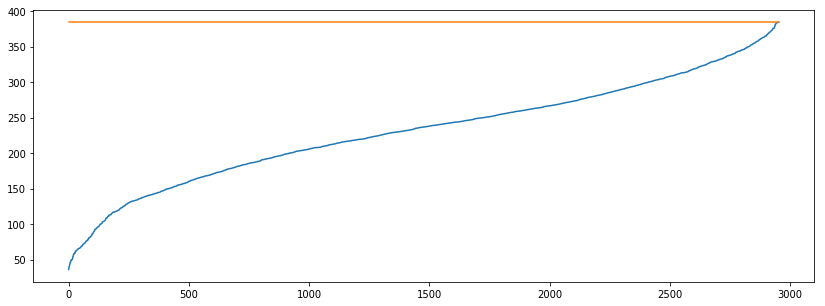

In [38]:
all_areas = sorted(all_areas)
plt.figure(figsize=(14, 5))
plt.plot(np.sqrt(all_areas))
plt.plot([0, len(all_areas)], [384, 384])
# plt.bar(list(range(len(dist))), dist)
plt.show()
plt.close()

In [3]:
import json
with open('.cbis_cache.json') as fl:
    refs = json.load(fl)

In [4]:
print(len(refs))

3031


In [6]:
import pydicom
import os, sys
import numpy as np

areas = []
for ii, ent in enumerate(refs):
    for mpath in ent['masks']:
        with pydicom.dcmread(mpath) as db:
            xcoords, _ = np.nonzero(db.pixel_array)
            areas.append({
                'mask': mpath,
                'area': len(xcoords),
                'size': db.pixel_array.shape
            })
            
    sys.stdout.write('%d/%d     \r' % (ii, len(refs)))
    sys.stdout.flush()

In [7]:
heights = [ent['size'][0] for ent in areas]
widths = [ent['size'][1] for ent in areas]

print(np.max(widths))
print(np.max(heights))

5431
7111


## import matplotlib.pyplot as plt

values = [ent['area'] for ent in areas]
values = sorted(values)
plt.figure(figsize=(14, 5))
plt.plot(values)
plt.show()
plt.close()

In [ ]:
print(np.mean(values))
print(np.min(values), np.max(values))

# for clas: 256
buckets = [
    128, # 256 (x1)
    256, # 512 (x0.5)
    512, # 1024 (x0.25)
]
# print('Examine:' )

bs = [list() for _ in range(len(buckets))]
toobig = []
for ar in areas:
    if ar['area'] < 170**2: bs[0].append(ar)
    elif ar['area'] < 342**2: bs[1].append(ar)
    elif ar['area'] < 682**2: bs[2].append(ar)
    else: toobig.append(ar)
        
print(len(bs[0]), len(bs[1]), len(bs[2]), len(toobig))
# print(len([ar for ar in areas if ar < 256**2]))
# print(len([ar for ar in areas if ar > 256**2]))

In [ ]:

for ar in areas:
    if 'Mass' not in ar['mask']: continue
    if ar['area'] < 256**2: bs[0].append(ar)
    elif ar['area'] < 512**2: bs[1].append(ar)
    elif ar['area'] < 1024**2: bs[2].append(ar)
    else: toobig.append(ar)
        
print(len(bs[0]), len(bs[1]), len(bs[2]), len(toobig))

# for ar in areas:
#     if 'Mass' in ar['mask']: continue
#     if ar['area'] < 170**2: bs[0].append(ar)
#     elif ar['area'] < 342**2: bs[1].append(ar)
#     elif ar['area'] < 682**2: bs[2].append(ar)
#     else: toobig.append(ar)
        
# print(len(bs[0]), len(bs[1]), len(bs[2]), len(toobig))
# print(len([ar for ar in areas if ar < 256**2]))
# print(len([ar for ar in areas if ar > 256**2]))
# print(len([ar for ar in areas if ar < 256**2]))
# print(len([ar for ar in areas if ar > 256**2]))

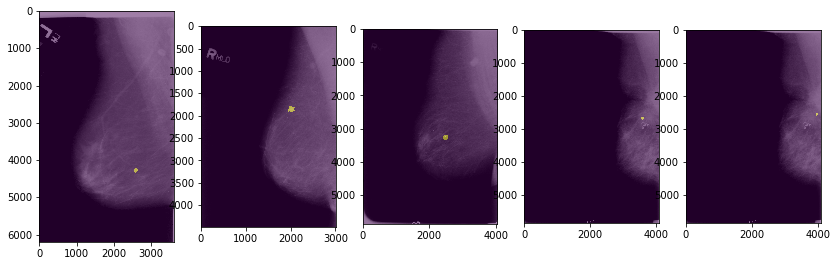

In [94]:
plt.figure(figsize=(14, 7))
from glob import glob
DPATH = '/home/ubuntu/datasets/chest/CBIS-DDSM'
for ii in range(5):
    ref = '_'.join(bs[0][ii]['mask'].split('CBIS-DDSM/')[1].split('/')[0].split('_')[:-1])
    impath = glob(glob(glob('%s/%s/*' % (DPATH, ref))[0] + '/*')[0] + '/*')[0]
    with pydicom.dcmread(impath) as db:
        rawimg = db.pixel_array
    with pydicom.dcmread(bs[0][ii]['mask']) as db:
        rawmask = db.pixel_array
    assert rawimg.shape == rawmask.shape
    
    plt.subplot(1, 5, ii+1)
    plt.imshow(rawimg, cmap='gray')
    plt.imshow(rawmask, alpha=0.5)
#     print()
#     print(ref)
plt.show()
plt.close()

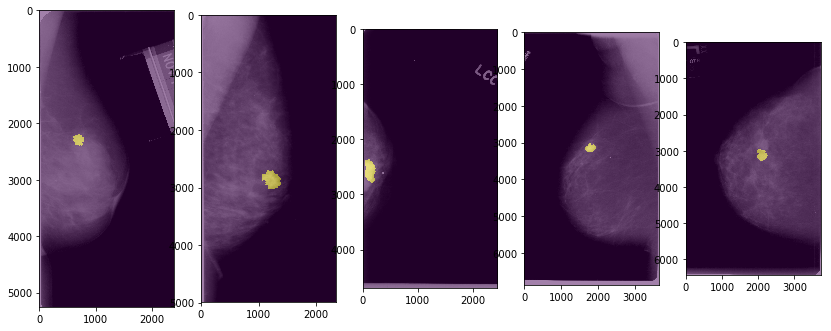

In [95]:
plt.figure(figsize=(14, 7))
from glob import glob
DPATH = '/home/ubuntu/datasets/chest/CBIS-DDSM'
for ii in range(5):
    ref = '_'.join(bs[1][ii]['mask'].split('CBIS-DDSM/')[1].split('/')[0].split('_')[:-1])
    impath = glob(glob(glob('%s/%s/*' % (DPATH, ref))[0] + '/*')[0] + '/*')[0]
    with pydicom.dcmread(impath) as db:
        rawimg = db.pixel_array
    with pydicom.dcmread(bs[1][ii]['mask']) as db:
        rawmask = db.pixel_array
    assert rawimg.shape == rawmask.shape
    
    plt.subplot(1, 5, ii+1)
    plt.imshow(rawimg, cmap='gray')
    plt.imshow(rawmask, alpha=0.5)
#     print()
#     print(ref)
plt.show()
plt.close()

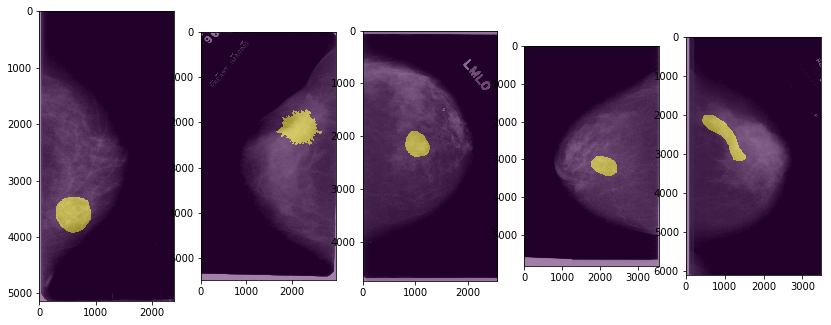

In [96]:
plt.figure(figsize=(14, 7))
from glob import glob
DPATH = '/home/ubuntu/datasets/chest/CBIS-DDSM'
for ii in range(5):
    ref = '_'.join(bs[2][ii]['mask'].split('CBIS-DDSM/')[1].split('/')[0].split('_')[:-1])
    impath = glob(glob(glob('%s/%s/*' % (DPATH, ref))[0] + '/*')[0] + '/*')[0]
    with pydicom.dcmread(impath) as db:
        rawimg = db.pixel_array
    with pydicom.dcmread(bs[2][ii]['mask']) as db:
        rawmask = db.pixel_array
    assert rawimg.shape == rawmask.shape
    
    plt.subplot(1, 5, ii+1)
    plt.imshow(rawimg, cmap='gray')
    plt.imshow(rawmask, alpha=0.5)
#     print()
#     print(ref)
plt.show()
plt.close()

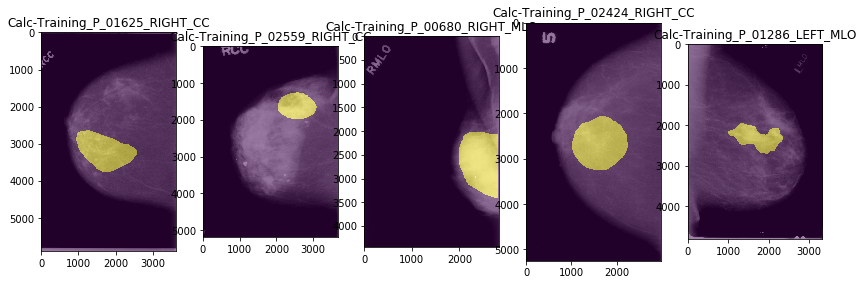

In [59]:
plt.figure(figsize=(14, 7))
from glob import glob
DPATH = '/home/ubuntu/datasets/chest/CBIS-DDSM'
for ii in range(5):
    ref = '_'.join(toobig[ii]['mask'].split('CBIS-DDSM/')[1].split('/')[0].split('_')[:-1])
    impath = glob(glob(glob('%s/%s/*' % (DPATH, ref))[0] + '/*')[0] + '/*')[0]
    with pydicom.dcmread(impath) as db:
        rawimg = db.pixel_array
    with pydicom.dcmread(toobig[ii]['mask']) as db:
        rawmask = db.pixel_array
    assert rawimg.shape == rawmask.shape
    
    plt.subplot(1, 5, ii+1)
    plt.gca().set_title(ref)
    plt.imshow(rawimg, cmap='gray')
    plt.imshow(rawmask, alpha=0.5)
#     print()
#     print(ref)
plt.show()
plt.close()

/home/ubuntu/datasets/chest/CBIS-DDSM/Calc-Training_P_01625_RIGHT_CC_1/09-06-2017-DDSM-11003/1-ROI mask images-80924/000001.dcm


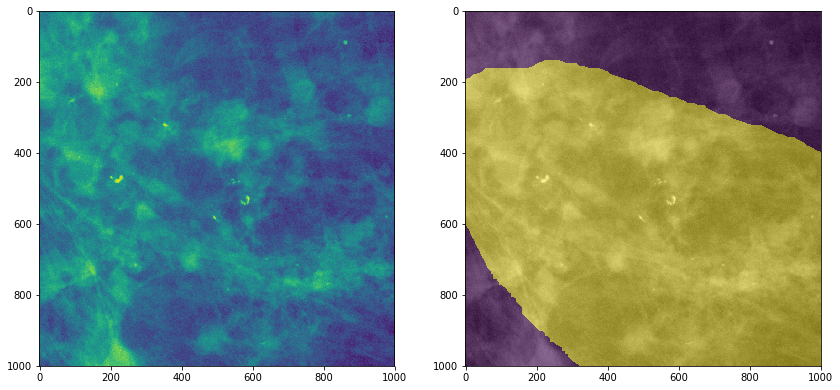

In [2]:
from utils import *

plot_raw('01625_RIGHT_CC', zoom=(1000, 2500))

/home/ubuntu/datasets/chest/CBIS-DDSM/Calc-Training_P_02559_RIGHT_CC_1/09-06-2017-DDSM-80189/1-ROI mask images-22467/000001.dcm


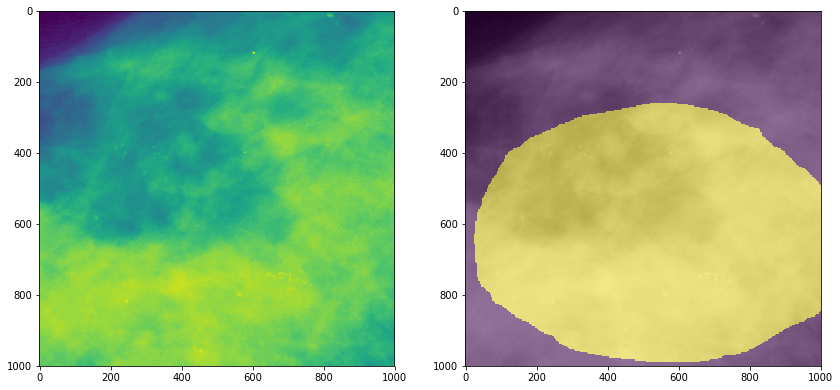

In [105]:
plot_raw('02559_RIGHT_CC', zoom=(2000, 1000))

/home/ubuntu/datasets/chest/CBIS-DDSM/Calc-Training_P_02459_RIGHT_CC_1/09-06-2017-DDSM-34779/1-ROI mask images-50731/000001.dcm


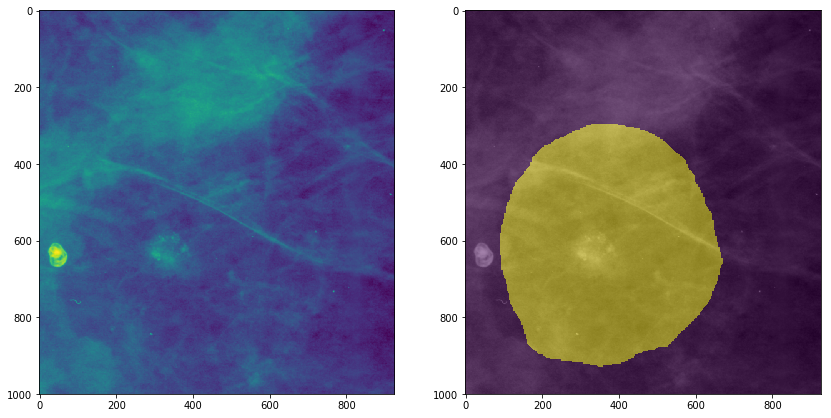

In [4]:
plot_raw('02459_RIGHT_CC', zoom=(1700, 2000))

/home/ubuntu/datasets/chest/CBIS-DDSM/Calc-Training_P_01136_RIGHT_CC_1/09-06-2017-DDSM-10748/1-ROI mask images-14633/000001.dcm


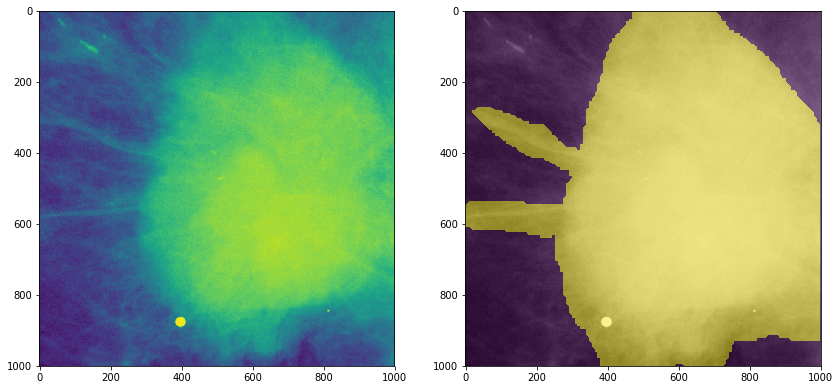

In [6]:
plot_raw('01136_RIGHT_CC', zoom=(2500,3000))

/home/ubuntu/datasets/chest/CBIS-DDSM/Calc-Training_P_01286_LEFT_MLO_1/09-06-2017-DDSM-05215/1-ROI mask images-96726/000001.dcm


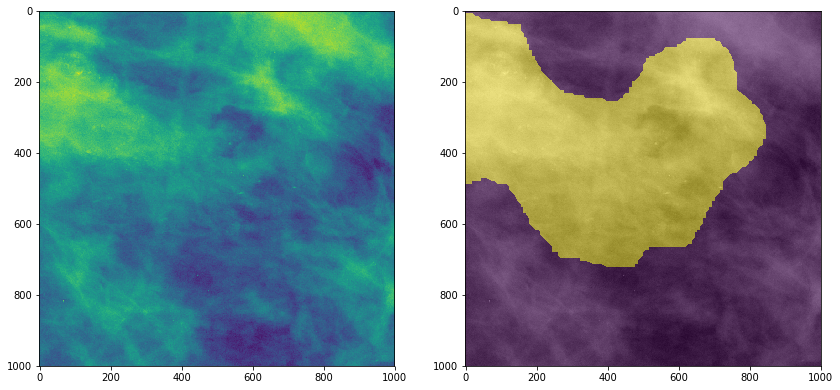

In [9]:
plot_raw('01286_LEFT_MLO', zoom=(1500, 2000))